In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from collections import Counter
import os

# Random Prototyping

In [41]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)

# Convert dataset to DataLoader (load all at once)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)

# Extract entire train and test data
train_data = torch.cat([data for data, _ in train_loader], dim=0)
train_labels = torch.cat([labels for _, labels in train_loader], dim=0)

test_data = torch.cat([data for data, _ in test_loader], dim=0)
test_labels = torch.cat([labels for _, labels in test_loader], dim=0)

# Flatten images from (N, 1, 28, 28) -> (N, 784)
train_data = train_data.view(train_data.shape[0], -1).to(device)  # (60000, 784)
test_data = test_data.view(test_data.shape[0], -1).to(device)  # (10000, 784)

train_labels = train_labels.to(device)
test_labels = test_labels.to(device)


Using device: cpu


In [35]:
num_subsets = np.array([10000, 5000, 1000])

In [42]:
def compute_accuracy(test_data, prototype_data, prototype_labels, k=1):
    # Compute full pairwise distance matrix in one go
    print("Computing full distance matrix...")
    distances = torch.cdist(test_data, prototype_data)  # Shape: (10000, 60000)

    # Get indices of k nearest neighbors
    k_indices = torch.topk(distances, k, largest=False).indices  # Shape: (10000, k)

    # Retrieve the k nearest labels
    k_labels = prototype_labels[k_indices]  # Shape: (10000, k)

    # Majority voting for prediction
    pred_labels = torch.mode(k_labels, dim=1).values  # Shape: (10000,)

    # Compute accuracy
    accuracy = (pred_labels == test_labels).float().mean().item()
    print(f'{k}-NN accuracy on full test set (no batching): {accuracy:.4f}')
    return accuracy

In [43]:
accuracy_dict = {}
for subset in num_subsets:
    accuracy_list = []
    for _ in range(30):
        random_indicies = torch.randperm(train_data.shape[0])[:subset]
        prototype_train_data = train_data[random_indicies]
        prototype_train_labels = train_labels[random_indicies]
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
        accuracy_list.append(accuracy)
    accuracy_dict[subset] = accuracy_list

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9482
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9492
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9478
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9511
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9477
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9470
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9501
Computing full distance matrix...


KeyboardInterrupt: 

In [7]:
accuracy_df = pd.DataFrame(accuracy_dict)

In [8]:
accuracy_df.mean()

10000    0.948797
5000     0.935250
1000     0.885223
dtype: float64

In [9]:
accuracy_df.std(ddof=1)

10000    0.001535
5000     0.002041
1000     0.004759
dtype: float64

# K Means

## K Means

### Base Functions

In [10]:
# Perform K-Means clustering
def kmeans(X, k, num_iters=100, tol=1e-4):
    """
    Runs K-Means clustering on tensor X.
    
    Args:
    - X (Tensor): Data points of shape (N, D)
    - k (int): Number of clusters
    - num_iters (int): Maximum number of iterations
    - tol (float): Tolerance for convergence
    
    Returns:
    - cluster_assignments (Tensor): Cluster labels for each point
    - centroids (Tensor): Final cluster centroids
    """
    N, D = X.shape
    device = X.device

    # 1️⃣ Randomly initialize centroids
    indices = torch.randperm(N)[:k]  
    centroids = X[indices]  # (k, D)

    for i in range(num_iters):
        # 2️⃣ Compute distances to centroids
        distances = torch.cdist(X, centroids)  # (N, k)

        # 3️⃣ Assign each point to the nearest centroid
        cluster_assignments = torch.argmin(distances, dim=1)  # (N,)

        # 4️⃣ Compute new centroids
        new_centroids = torch.stack([X[cluster_assignments == c].mean(dim=0) for c in range(k)])

        # 5️⃣ Check for convergence
        if torch.allclose(new_centroids, centroids, atol=tol):
            print(f'Converged at iteration {i}')
            break
        centroids = new_centroids

    return cluster_assignments, centroids

# Function to assign labels to centroids
def assign_labels(cluster_labels, y_true, k):
    """
    Assigns a label to each K-Means cluster using majority voting.
    
    Args:
    - cluster_labels (Tensor): Cluster assignments for each point
    - y_true (Tensor): True MNIST labels
    - k (int): Number of clusters

    Returns:
    - cluster_to_label (list): List where index `i` corresponds to cluster `i`'s assigned label
    """
    cluster_to_label = [-1] * k  # Initialize list with -1 for empty clusters

    for cluster in range(k):
        # Get all true labels for this cluster
        cluster_indices = (cluster_labels == cluster).nonzero(as_tuple=True)[0]
        true_labels = y_true[cluster_indices]

        # Find the most common label in this cluster
        if len(true_labels) > 0:
            most_common_label = Counter(true_labels.tolist()).most_common(1)[0][0]
            cluster_to_label[cluster] = most_common_label

    return cluster_to_label


### Create Centroids

In [22]:
for subset in num_subsets:
    if os.path.exists(f"mnist_centroids/mnist_kmeans_centroids_{subset}.pth"):
        continue
    else:
        cluster_labels, centroids = kmeans(train_data, subset)
        cluster_to_label = assign_labels(cluster_labels, train_labels, subset)
        torch.save(centroids, f"mnist_kmeans_centroids_{subset}.pth")
        torch.save(cluster_to_label, f"mnist_kmeans_cluster_labels_{subset}.pth")

### Make Predictions

In [24]:
accuracy_dict_kmeans = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
    accuracy_dict_kmeans[subset] = [accuracy]

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9594
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9560
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9408


In [25]:
accuracy_df_kmeans = pd.DataFrame(accuracy_dict_kmeans)
accuracy_df_kmeans

,10000,5000,1000
0,0.9594,0.956,0.9408


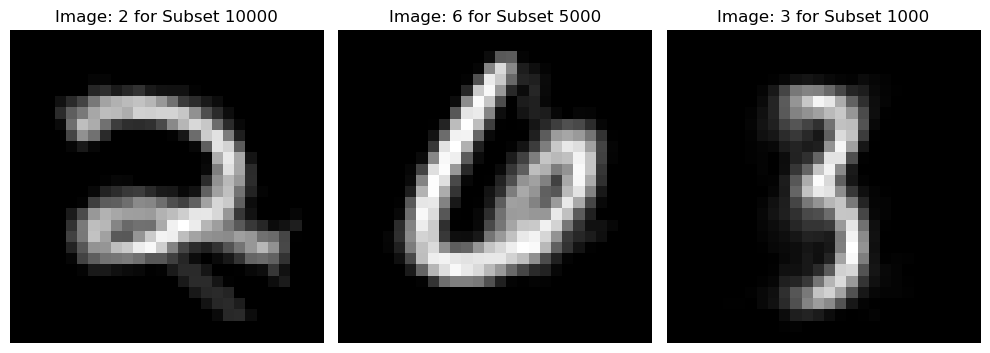

In [20]:
fig, axes = plt.subplots(1, len(num_subsets), figsize=(10, 8))
for i, subset in enumerate(num_subsets):
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    ax = axes[i]
    ax.imshow(prototype_train_data[50].reshape(28, 28), cmap='gray')
    ax.set_title(f"Image: {prototype_train_labels[50]} for Subset {subset}")
    ax.axis('off')
plt.tight_layout()
plt.show()


## K Means ++

### Base Functions

In [14]:
def kmeans_plusplus(X, k):
    """
    Initializes centroids using the K-Means++ algorithm.
    
    Args:
    - X (Tensor): Data points of shape (N, D)
    - k (int): Number of clusters
    
    Returns:
    - centroids (Tensor): Initialized centroids of shape (k, D)
    """
    N, D = X.shape
    device = X.device
    centroids = torch.empty((k, D), device=device)  # To store k centroids

    # 1️⃣ Select first centroid randomly
    first_idx = torch.randint(0, N, (1,))
    centroids[0] = X[first_idx]

    # 2️⃣ Select remaining centroids using distance-based probability
    for i in range(1, k):
        distances = torch.cdist(X, centroids[:i]).min(dim=1).values ** 2
        probabilities = distances / distances.sum()  # Normalize to probabilities
        next_idx = torch.multinomial(probabilities, 1)  # Sample next centroid
        centroids[i] = X[next_idx]

    return centroids

def kmeans(X, k, num_iters=100, tol=1e-4):
    """
    Performs K-Means clustering with K-Means++ initialization.
    
    Args:
    - X (Tensor): Data points of shape (N, D)
    - k (int): Number of clusters
    - num_iters (int): Number of iterations
    - tol (float): Tolerance for convergence
    
    Returns:
    - cluster_assignments (Tensor): Cluster indices for each point
    - centroids (Tensor): Final cluster centroids
    """
    N, D = X.shape
    device = X.device

    # Initialize centroids using K-Means++
    centroids = kmeans_plusplus(X, k)

    for _ in range(num_iters):
        # Compute distances from each point to each centroid
        distances = torch.cdist(X, centroids)  # (N, k)

        # Assign each point to the nearest centroid
        cluster_assignments = torch.argmin(distances, dim=1)  # (N,)

        # Compute new centroids
        new_centroids = torch.stack([X[cluster_assignments == c].mean(dim=0) for c in range(k)])

        # Check for convergence (if centroids change very little)
        if torch.allclose(new_centroids, centroids, atol=tol):
            print("Converged early!")
            break

        centroids = new_centroids

    return cluster_assignments, centroids


### Create Centroids

In [ ]:
for subset in num_subsets:
    if os.path.exists(f"mnist_centroids/mnist_kmeans_plus_centroids_{subset}.pth"):
        continue
    else:
        cluster_labels, centroids = kmeans(train_data, subset)
        cluster_to_label = assign_labels(cluster_labels, train_labels, subset)
        torch.save(centroids, f"mnist_kmeans_plus_centroids_{subset}.pth")
        torch.save(cluster_to_label, f"mnist_kmeans_plus_cluster_labels_{subset}.pth")

### Make Predictions

In [ ]:
accuracy_dict_kmeans_plus = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
    accuracy_dict_kmeans_plus[subset] = [accuracy]

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9606
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9583
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9427


In [18]:
accuracy_df_kmeans_plus = pd.DataFrame(accuracy_dict_kmeans_plus)
accuracy_df_kmeans_plus

,10000,5000,1000
0,0.9606,0.9583,0.9427


In [19]:
accuracy_df.mean()

10000    0.948797
5000     0.935250
1000     0.885223
dtype: float64

In [20]:
accuracy_df_kmeans

,10000,5000,1000
0,0.9594,0.956,0.9408


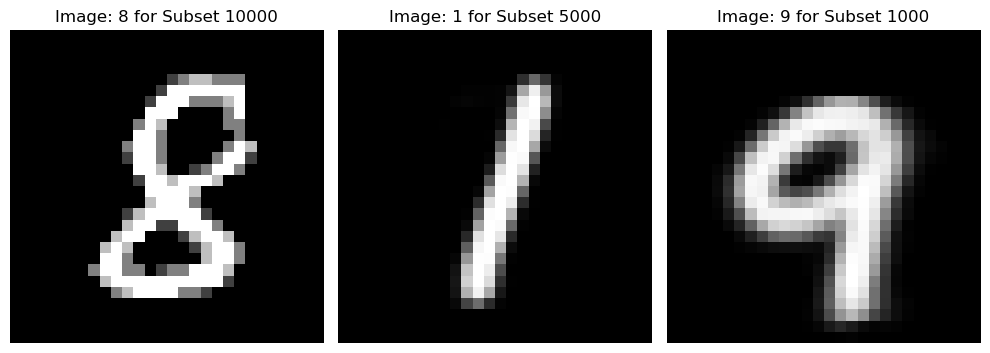

In [21]:
fig, axes = plt.subplots(1, len(num_subsets), figsize=(10, 8))
for i, subset in enumerate(num_subsets):
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    ax = axes[i]
    ax.imshow(prototype_train_data[50].reshape(28, 28), cmap='gray')
    ax.set_title(f"Image: {prototype_train_labels[50]} for Subset {subset}")
    ax.axis('off')
plt.tight_layout()
plt.show()


## 3 Nearest Neighbors

### Random Selection

In [26]:
accuracy_dict_3 = {}
for subset in num_subsets:
    accuracy_list = []
    for _ in range(30):
        random_indicies = torch.randperm(train_data.shape[0])[:subset]
        prototype_train_data = train_data[random_indicies]
        prototype_train_labels = train_labels[random_indicies]
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k=3)
        accuracy_list.append(accuracy)
    accuracy_dict_3[subset] = accuracy_list

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9495
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9504
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9494
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9509
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9484
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9497
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9500
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9487
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9478
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9502
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9489
Computing full distance matrix...
k-NN accu

In [27]:
accuracy_df_3 = pd.DataFrame(accuracy_dict_3)
accuracy_df_3.mean(), accuracy_df_3.std(ddof=1)

(10000    0.949440
 5000     0.935373
 1000     0.879693
 dtype: float64,
 10000    0.001325
 5000     0.002438
 1000     0.005019
 dtype: float64)

### K Means

In [28]:
accuracy_dict_kmeans_3 = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k=3)
    accuracy_dict_kmeans_3[subset] = [accuracy]

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9613
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9588
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9395


### K Means ++

In [29]:
accuracy_dict_kmeans_plus_3 = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k=3)
    accuracy_dict_kmeans_plus_3[subset] = [accuracy]

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9635
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9581
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9441


## 5 Nearest Neigbors

### Random Selection

In [31]:
accuracy_dict_5 = {}
for subset in num_subsets:
    accuracy_list = []
    for _ in range(30):
        random_indicies = torch.randperm(train_data.shape[0])[:subset]
        prototype_train_data = train_data[random_indicies]
        prototype_train_labels = train_labels[random_indicies]
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k=5)
        accuracy_list.append(accuracy)
    accuracy_dict_5[subset] = accuracy_list

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9495
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9493
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9458
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9483
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9504
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9468
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9479
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9490
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9469
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9489
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9495
Computing full distance matrix...
k-NN accu

In [32]:
accuracy_df_5 = pd.DataFrame(accuracy_dict_5)
accuracy_df_5.mean(), accuracy_df_5.std(ddof=1)

(10000    0.948693
 5000     0.934390
 1000     0.878300
 dtype: float64,
 10000    0.001676
 5000     0.002001
 1000     0.003612
 dtype: float64)

### K Means

In [33]:
accuracy_dict_kmeans_5 = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k=5)
    accuracy_dict_kmeans_5[subset] = [accuracy]

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9621
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9590
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9388


### K Means++

In [34]:
accuracy_dict_kmeans_plus_5 = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k=5)
    accuracy_dict_kmeans_plus_5[subset] = [accuracy]

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9644
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9611
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9423


## 10 Nearest Neighbors

### Random Selection

In [35]:
accuracy_dict_10 = {}
for subset in num_subsets:
    accuracy_list = []
    for _ in range(30):
        random_indicies = torch.randperm(train_data.shape[0])[:subset]
        prototype_train_data = train_data[random_indicies]
        prototype_train_labels = train_labels[random_indicies]
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k=10)
        accuracy_list.append(accuracy)
    accuracy_dict_10[subset] = accuracy_list

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9452
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9412
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9439
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9431
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9444
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9446
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9419
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9450
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9435
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9453
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9444
Computing full distance matrix...
k-NN accu

In [36]:
accuracy_df_10 = pd.DataFrame(accuracy_dict_10)
accuracy_df_10.mean(), accuracy_df_10.std(ddof=1)

(10000    0.943560
 5000     0.928453
 1000     0.864613
 dtype: float64,
 10000    0.001351
 5000     0.001965
 1000     0.004933
 dtype: float64)

### K Means

In [37]:
accuracy_dict_kmeans_10 = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k=10)
    accuracy_dict_kmeans_10[subset] = [accuracy]

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9600
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9557
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9319


### K Means ++

In [38]:
accuracy_dict_kmeans_plus_10 = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k=10)
    accuracy_dict_kmeans_plus_10[subset] = [accuracy]

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9610
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9594
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9364


# Full Tests

In [64]:
full_accuracy_df_random = pd.DataFrame()

num_neighbors = np.arange(1,30,2)

for k in num_neighbors:
    accuracy_dict_random_per_neigbor = {}
    for subset in num_subsets:
        accuracy_list = []
        for _ in range(30):
            random_indicies = torch.randperm(train_data.shape[0])[:subset]
            prototype_train_data = train_data[random_indicies]
            prototype_train_labels = train_labels[random_indicies]
            accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
            accuracy_list.append(accuracy)
        accuracy_dict_random_per_neigbor[subset] = accuracy_list
    temp = pd.DataFrame(accuracy_dict_random_per_neigbor)
    temp['k'] = k
    full_accuracy_df_random = pd.concat([full_accuracy_df_random, temp], axis=0)

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9467
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9466
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9496
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9449
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9486
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9473
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9462
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9498
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9473
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9503
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.9483
Computing full distance matrix...
1-NN accu

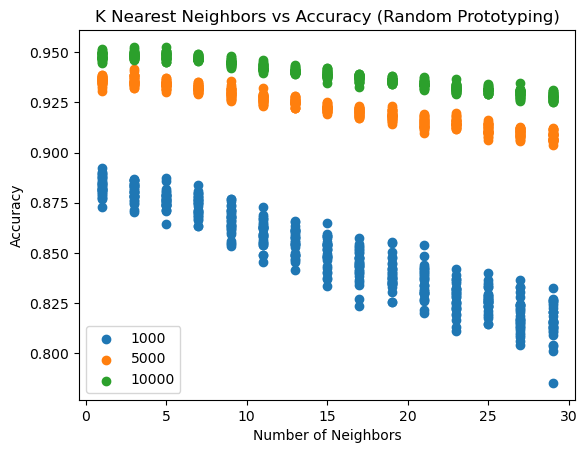

In [66]:
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[1000], label='1000')
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[5000], label='5000')
plt.scatter(full_accuracy_df_random['k'], full_accuracy_df_random[10000], label='10000')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (Random Prototyping)')
plt.legend()
plt.show()

## K Means

In [61]:
full_accuracy_df_kmeans = pd.DataFrame()

num_neighbors = np.arange(1,30,2)

for k in num_neighbors:
    accuracy_dict_kmean_per_neigbor = {}
    for subset in num_subsets:
        prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_centroids_{subset}.pth", weights_only=False)
        prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
        accuracy_dict_kmean_per_neigbor[subset] = [accuracy]
    temp = pd.DataFrame(accuracy_dict_kmean_per_neigbor)
    full_accuracy_df_kmeans = pd.concat([full_accuracy_df_kmeans, temp], axis=0)
full_accuracy_df_kmeans['k'] = num_neighbors

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9594
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9560
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9408
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9613
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9588
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9395
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9621
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9590
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9388
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9617
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9586
Computing full distance matrix...
k-NN accu

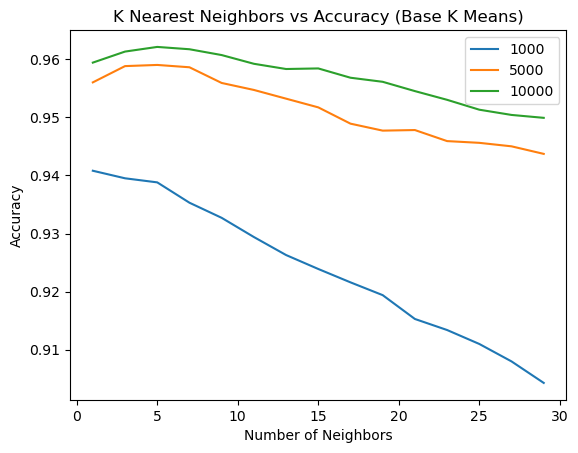

In [62]:
plt.plot(full_accuracy_df_kmeans['k'], full_accuracy_df_kmeans[1000], label='1000')
plt.plot(full_accuracy_df_kmeans['k'], full_accuracy_df_kmeans[5000], label='5000')
plt.plot(full_accuracy_df_kmeans['k'], full_accuracy_df_kmeans[10000], label='10000')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (Base K Means)')
plt.legend()
plt.show()

## K means ++

In [63]:
full_accuracy_df_kmeans_plus = pd.DataFrame()

num_neighbors = np.arange(1,30,2)

for k in num_neighbors:
    accuracy_dict_kmean_per_neigbor = {}
    for subset in num_subsets:
        prototype_train_data = torch.load(f"mnist_centroids/mnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
        prototype_train_labels = torch.tensor(torch.load(f"mnist_centroids/mnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
        accuracy_dict_kmean_per_neigbor[subset] = [accuracy]
    temp = pd.DataFrame(accuracy_dict_kmean_per_neigbor)
    full_accuracy_df_kmeans_plus = pd.concat([full_accuracy_df_kmeans_plus, temp], axis=0)
full_accuracy_df_kmeans_plus['k'] = num_neighbors

Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9606
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9583
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9427
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9635
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9581
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9441
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9644
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9611
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9423
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9627
Computing full distance matrix...
k-NN accuracy on full test set (no batching): 0.9597
Computing full distance matrix...
k-NN accu

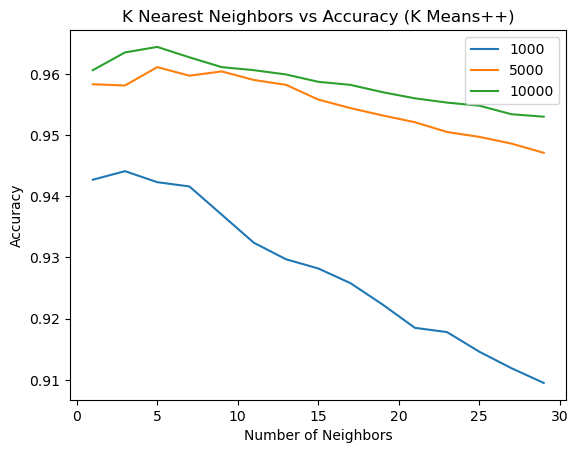

In [64]:
plt.plot(full_accuracy_df_kmeans_plus['k'], full_accuracy_df_kmeans_plus[1000], label='1000')
plt.plot(full_accuracy_df_kmeans_plus['k'], full_accuracy_df_kmeans_plus[5000], label='5000')
plt.plot(full_accuracy_df_kmeans_plus['k'], full_accuracy_df_kmeans_plus[10000], label='10000')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (K Means++)')
plt.legend()
plt.show()